In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.backends.backend_pdf import PdfPages

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('./data/Bundesliga.csv')
df2 = pd.read_csv('./data/Bundesliga2.csv')

## Part 1: Trend Analysis

### 1. Analyse trend of goals per season. 
    For example total goals per match, average goals per match

In [8]:
df['FTHG'] = pd.to_numeric(df['FTHG'], errors='coerce')
df['FTAG'] = pd.to_numeric(df['FTAG'], errors='coerce')
df['total_goals'] = df['FTHG'] + df['FTAG']

In [ ]:
total_goals_per_season = df.groupby('SEASON')['total_goals'].sum()

matches_per_season = df.groupby('SEASON').size()
avg_goals_per_match = total_goals_per_season / matches_per_season

home_goals_per_season = df.groupby('SEASON')['FTHG'].sum()
away_goals_per_season = df.groupby('SEASON')['FTAG'].sum()

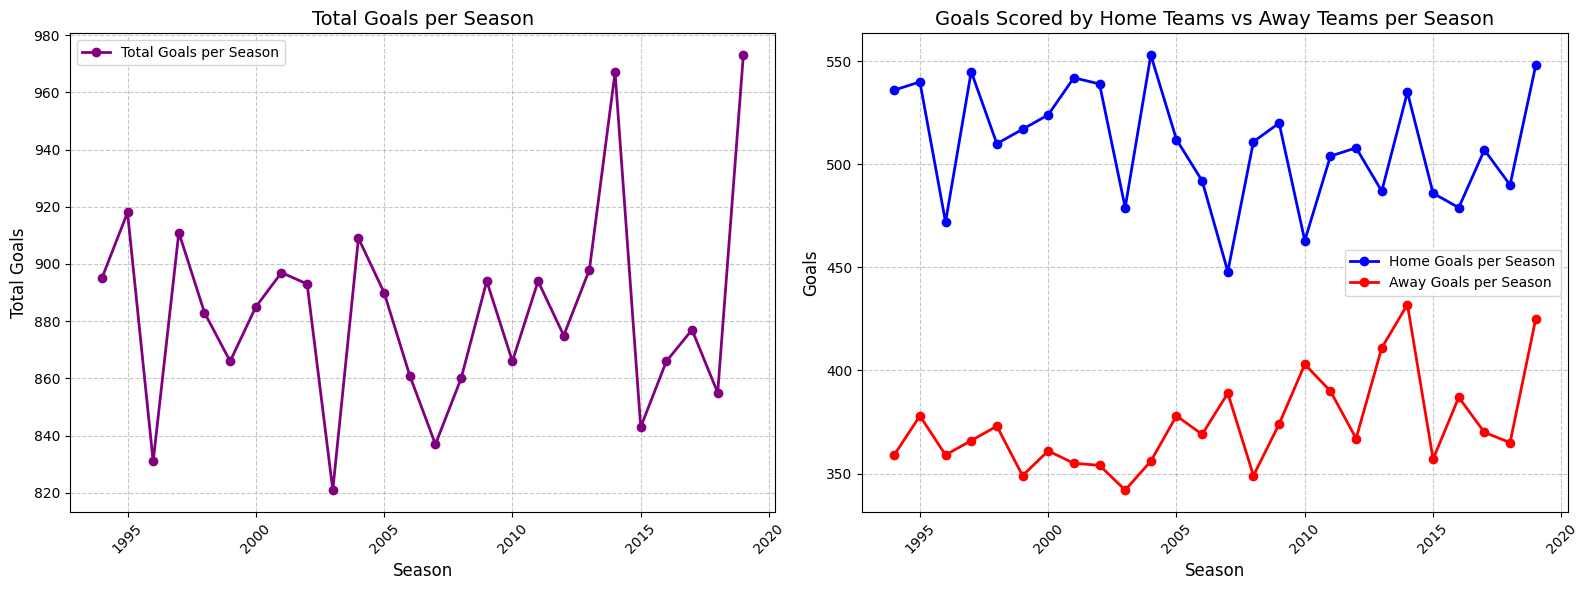

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6)) 

axes[0].plot(total_goals_per_season.index, total_goals_per_season, label='Total Goals per Season', color='purple', marker='o', markersize=6, linestyle='-', linewidth=2)
axes[0].set_xlabel('Season', fontsize=12)
axes[0].set_ylabel('Total Goals', fontsize=12)
axes[0].set_title('Total Goals per Season', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].tick_params(axis='both', labelsize=10)
axes[0].legend(fontsize=10)
axes[0].tick_params(axis='x', rotation=45)

axes[1].plot(home_goals_per_season.index, home_goals_per_season, label='Home Goals per Season', color='blue', marker='o', markersize=6, linestyle='-', linewidth=2)
axes[1].plot(away_goals_per_season.index, away_goals_per_season, label='Away Goals per Season', color='red', marker='o', markersize=6, linestyle='-', linewidth=2)
axes[1].set_xlabel('Season', fontsize=12)
axes[1].set_ylabel('Goals', fontsize=12)
axes[1].set_title('Goals Scored by Home Teams vs Away Teams per Season', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].tick_params(axis='both', labelsize=10)
axes[1].legend(fontsize=10)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 2. Goal Distribution Per Season. 
    Use appropriate type of graphs for goals per match, year-wise. Colorcode by whether average is above or below 2.5 (over/under bet threshold).

In [ ]:
df2['goals_per_match'] = df2['GF'] / df2['M']
df2['color'] = df2['goals_per_match'].apply(lambda x: 'green' if x > 2.5 else 'red')

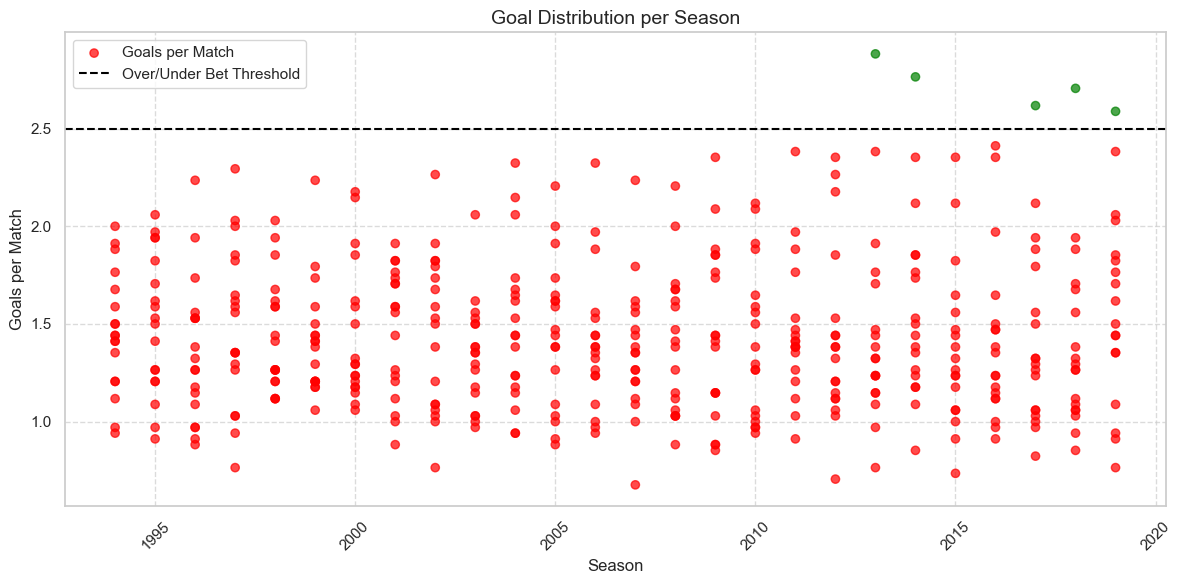

In [16]:
plt.figure(figsize=(12, 6))
plt.scatter(df2['SEASON'], df2['goals_per_match'], c=df2['color'], label='Goals per Match', alpha=0.7)

plt.xlabel('Season', fontsize=12)
plt.ylabel('Goals per Match', fontsize=12)
plt.title('Goal Distribution per Season', fontsize=14)
plt.axhline(2.5, color='black', linestyle='--', label='Over/Under Bet Threshold (2.5)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

plt.legend(['Goals per Match', 'Over/Under Bet Threshold'], loc='upper left')
plt.show()


###  Create line charts for each season.

    Visualize trend of goals for each team that played in that season.
    Highlight only Bayern Munchen with red color. Rest should be gray. Add appropriate title that will
    contain information about season and total scored goals. Add footnote mentioning total number of
    goals scored by Bayern Munchen for that season. Save all graphs in pdf

In [ ]:
pdf_pages = PdfPages('./data/bayern_goals_per_season.pdf')

for season in df['SEASON'].unique():
    season_data = df[df['SEASON'] == season]

    season_data['DATE'] = pd.to_datetime(season_data['DATE'])
    season_data['YearMonth'] = season_data['DATE'].dt.to_period('M')

    # Calculate the total goals scored by Bayern Munich for the season
    bayern_data = season_data[(season_data['HOMETEAM'] == 'Bayern Munich') | (season_data['AWAYTEAM'] == 'Bayern Munich')]
    bayern_goals = bayern_data.groupby('SEASON').apply(lambda x: x['FTHG'].sum() + x['FTAG'].sum()).sum()

    plt.figure(figsize=(14, 8))

    handles = []
    for team_name in season_data['HOMETEAM'].unique():
        home_team_data = season_data[season_data['HOMETEAM'] == team_name]
        home_goals = home_team_data.groupby('YearMonth')['FTHG'].sum()

        away_team_data = season_data[season_data['AWAYTEAM'] == team_name]
        away_goals = away_team_data.groupby('YearMonth')['FTAG'].sum()

        total_goals = home_goals.add(away_goals, fill_value=0)

        if team_name == "Bayern Munich":
            line, = plt.plot(total_goals.index.astype(str), total_goals, label='Bayern Munich', linewidth=2, color='red')
            handles.append(line)
        else:
            plt.plot(total_goals.index.astype(str), total_goals, label=team_name, linewidth=2, color='gray')

    plt.title(f"Monthly Goal Trends for {season} Season", fontsize=16, fontweight='bold')

    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Goals Scored', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.figtext(0.99, 0.01, f"Total Goals Scored by Bayern Munich: {bayern_goals}", horizontalalignment='right', fontsize=10, color='black', style='italic')

    plt.legend(handles=handles + [plt.Line2D([0], [0], color='gray', lw=2)], labels=['Bayern Munich', 'Other Teams'], loc='upper right')

    pdf_pages.savefig()
    plt.close()

pdf_pages.close()

## Part 2: Home Advantage Deconstructed (R or Python)

### 1. Create Heatmap of Home vs. Away Wins per Team per Season

In [ ]:
df['HomeWin'] = np.where(df['FTHG'] > df['FTAG'], 1, 0)
df['AwayWin'] = np.where(df['FTAG'] > df['FTHG'], 1, 0)

home_wins = df.groupby(['SEASON', 'HOMETEAM'])['HomeWin'].sum().reset_index()
away_wins = df.groupby(['SEASON', 'AWAYTEAM'])['AwayWin'].sum().reset_index()

home_wins.rename(columns={'HOMETEAM': 'Team', 'HomeWin': 'Wins'}, inplace=True)
away_wins.rename(columns={'AWAYTEAM': 'Team', 'AwayWin': 'Wins'}, inplace=True)

home_pivot = home_wins.pivot(index='Team', columns='SEASON', values='Wins')
away_pivot = away_wins.pivot(index='Team', columns='SEASON', values='Wins')

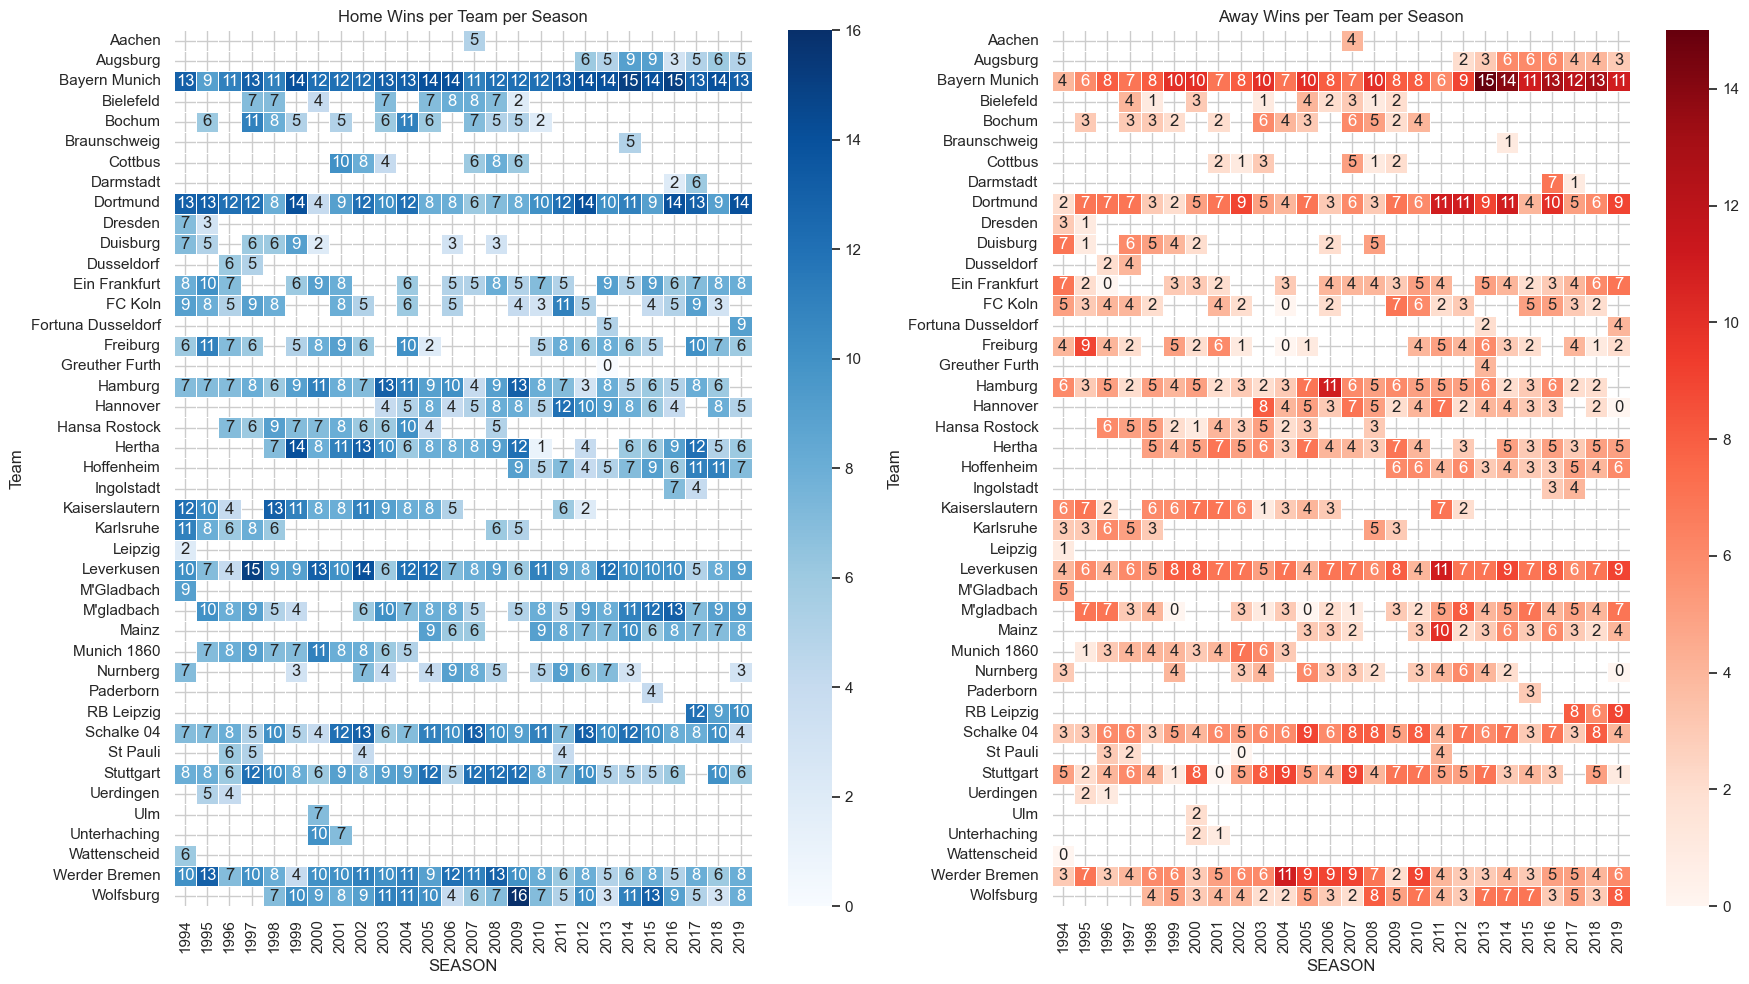

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

sns.heatmap(home_pivot, cmap='Blues', annot=True, fmt='.0f', linewidths=0.5, ax=axes[0])
axes[0].set_title('Home Wins per Team per Season')

sns.heatmap(away_pivot, cmap='Reds', annot=True, fmt='.0f', linewidths=0.5, ax=axes[1])
axes[1].set_title('Away Wins per Team per Season')

plt.tight_layout()
plt.show()

### 2. Point Differential Density: Create visualizations that will show difference per team for home and away game wins.

In [ ]:
df['HomeGoalDiff'] = df['FTHG'] - df['FTAG']
df['AwayGoalDiff'] = df['FTAG'] - df['FTHG']

goal_diff_data = df.melt(id_vars=['SEASON', 'HOMETEAM', 'AWAYTEAM'], 
                         value_vars=['HomeGoalDiff', 'AwayGoalDiff'], 
                         var_name='GameType', value_name='GoalDifference')

goal_diff_data['GameType'] = goal_diff_data['GameType'].map({'HomeGoalDiff': 'Home', 'AwayGoalDiff': 'Away'})

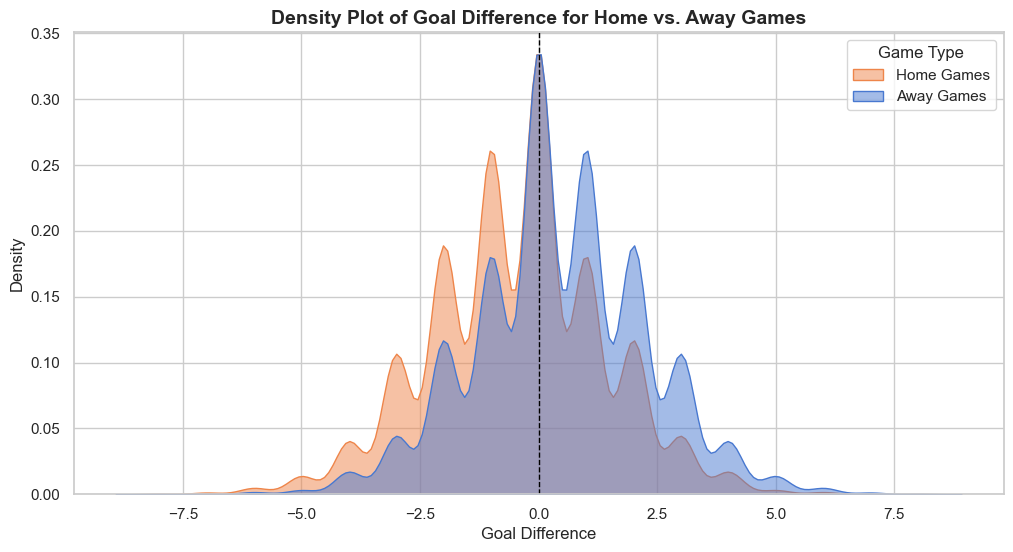

In [ ]:

plt.figure(figsize=(12, 6))
sns.kdeplot(data=goal_diff_data, x='GoalDifference', hue='GameType', fill=True, common_norm=False, alpha=0.5)

plt.title('Density Plot of Goal Difference for Home vs. Away Games', fontsize=14, fontweight='bold')
plt.xlabel('Goal Difference', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.axvline(0, color='black', linestyle='--', linewidth=1)  # Reference line for 0 goal difference
plt.legend(title='Game Type', labels=['Home Games', 'Away Games'])

plt.show()


##  Part 5: Overall performance

Define unique color for each team per season. For each season create horizontal bar plot using total \
number of points. Highlighting the winner with the unique color that you assigned to it. Save all \
graphs in pdf.

In [40]:
def plot_season(season_data, season):
    season_data_sorted = season_data.sort_values(by='DIFF', ascending=False)

    winner_team = season_data_sorted.loc[season_data_sorted['DIFF'].idxmax()]
    colors = plt.cm.get_cmap('tab20', len(season_data_sorted))

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(season_data_sorted['TEAM'], season_data_sorted['DIFF'], color=colors(np.arange(len(season_data_sorted))))

    winner_idx = season_data_sorted[season_data_sorted['TEAM'] == winner_team['TEAM']].index[0]
    bars[winner_idx].set_color('gold')

    ax.set_xlabel('Goal Difference')
    ax.set_title(f'Goal Difference per Team in Season {season}')
    ax.grid(True)

    return fig, ax

In [42]:
with PdfPages('./data/team_performance_by_season_py.pdf') as pdf:
    for season in df2['SEASON'].unique():
        season_data = df2[df2['SEASON'] == season].groupby('TEAM').agg({'DIFF': 'sum'}).reset_index()
        
        fig, ax = plot_season(season_data, season)

        pdf.savefig(fig)
        plt.close(fig)


## Part 6: Monte Carlo simulation

Use Monte Carlo simulation to predict how many goals will Bayern Munchen score for next 10 seasons. \
Repeat the same for Bayer Leverkusen and Borusia Dortmund. Compare results using appropriate visualization technique.

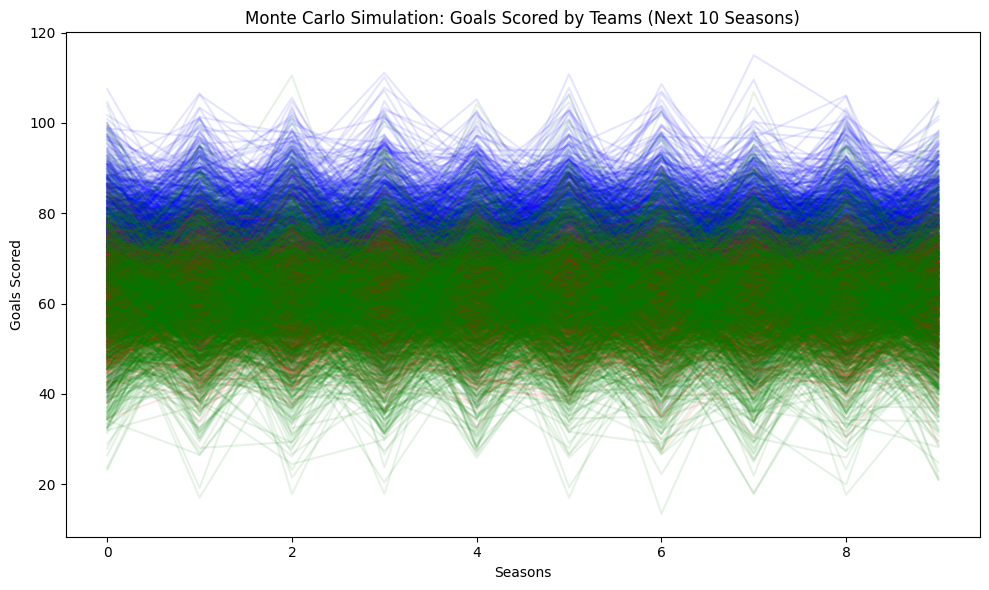

Bayern Munich (Season 10) - Mean: 73.59, 5th Percentile: 55.15, 95th Percentile: 90.91
Bayer Leverkusen (Season 10) - Mean: 61.10, 5th Percentile: 46.65, 95th Percentile: 74.73
Borussia Dortmund (Season 10) - Mean: 60.70, 5th Percentile: 40.71, 95th Percentile: 81.27


In [ ]:
bayern_goals = df2[df2['TEAM'] == 'Bayern Munich']['GF'].values
leverkusen_goals = df2[df2['TEAM'] == 'Leverkusen']['GF'].values
dortmund_goals = df2[df2['TEAM'] == 'Dortmund']['GF'].values

def calculate_drift_volatility(goals):
    drift = np.mean(goals)  # Average goals per season (drift)
    volatility = np.std(goals)  # Standard deviation of goals (volatility)
    return drift, volatility

bayern_drift, bayern_volatility = calculate_drift_volatility(bayern_goals)
leverkusen_drift, leverkusen_volatility = calculate_drift_volatility(leverkusen_goals)
dortmund_drift, dortmund_volatility = calculate_drift_volatility(dortmund_goals)

num_simulations = 1000 
num_seasons = 10

def monte_carlo_simulation(drift, volatility, num_simulations, num_seasons):
    simulations = np.zeros((num_simulations, num_seasons))
    for i in range(num_simulations):
        random_goals = np.random.normal(drift, volatility, num_seasons)
        simulations[i] = random_goals
    return simulations

bayern_simulations = monte_carlo_simulation(bayern_drift, bayern_volatility, num_simulations, num_seasons)
leverkusen_simulations = monte_carlo_simulation(leverkusen_drift, leverkusen_volatility, num_simulations, num_seasons)
dortmund_simulations = monte_carlo_simulation(dortmund_drift, dortmund_volatility, num_simulations, num_seasons)

plt.figure(figsize=(10, 6))

plt.plot(bayern_simulations.T, color='blue', alpha=0.1)
plt.plot(leverkusen_simulations.T, color='red', alpha=0.1)
plt.plot(dortmund_simulations.T, color='green', alpha=0.1)

plt.title('Monte Carlo Simulation: Goals Scored by Teams (Next 10 Seasons)')
plt.xlabel('Seasons')
plt.ylabel('Goals Scored')
plt.tight_layout()

plt.show()

final_bayern_goals = bayern_simulations[:, -1]
final_leverkusen_goals = leverkusen_simulations[:, -1]
final_dortmund_goals = dortmund_simulations[:, -1]

bayern_mean = np.mean(final_bayern_goals)
bayern_5th = np.percentile(final_bayern_goals, 5)
bayern_95th = np.percentile(final_bayern_goals, 95)

leverkusen_mean = np.mean(final_leverkusen_goals)
leverkusen_5th = np.percentile(final_leverkusen_goals, 5)
leverkusen_95th = np.percentile(final_leverkusen_goals, 95)

dortmund_mean = np.mean(final_dortmund_goals)
dortmund_5th = np.percentile(final_dortmund_goals, 5)
dortmund_95th = np.percentile(final_dortmund_goals, 95)

print(f"Bayern Munich (Season 10) - Mean: {bayern_mean:.2f}, 5th Percentile: {bayern_5th:.2f}, 95th Percentile: {bayern_95th:.2f}")
print(f"Bayer Leverkusen (Season 10) - Mean: {leverkusen_mean:.2f}, 5th Percentile: {leverkusen_5th:.2f}, 95th Percentile: {leverkusen_95th:.2f}")
print(f"Borussia Dortmund (Season 10) - Mean: {dortmund_mean:.2f}, 5th Percentile: {dortmund_5th:.2f}, 95th Percentile: {dortmund_95th:.2f}")
